# Vehicle Detection Project

This writeup contains both the code, my comments on how I implemented the pipeline.

To reuse the classifier I calculated execute the code from the section ** Evaluate the performance of the classifier **


# Pipeline stages

My Vehicle dection pipeline has the following number of stages:
- Pixel classification and colorspace distribution 
- HOG of oriented gradients
- SVM Classifier
- Window search 
- Heatmap

Let's focus on the first stage

# Pixel classification and colorspace distribution 

This stage extracts simple features from images :
- The pixel values
- The distribution of the pixel values

The premise of this choice of feature is that we would hope that the colors, brightess and their distribution in an image might provide enough information to discriminate a road from a vehicle.


In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
# NOTE: the next import is only valid 
# for scikit-learn version <= 0.17
# if you are using scikit-learn >= 0.18 then use this:
from sklearn.model_selection import train_test_split
# from sklearn.cross_validation import train_test_split

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # print('bin_spatial size:',len(features))
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector 
    # print('color_hist size:',len(hist_features))
    return hist_features


# Read in car and non-car images

#for filename in glob.iglob('./non-vehicles/**/*.png', recursive=True):
#    pass #print(filename)

notcars = glob.glob('./non-vehicles/**/*.png', recursive=True)
print('notcars:',len(notcars))

cars = glob.glob('./vehicles/**/*.png', recursive=True)
print('cars:',len(cars))


notcars: 8968
cars: 8792


# HOG classification


According to Wikipedia a Histogram of Oriented Gradient (HOG)  "counts occurrences of gradient orientation in localized portions of an image". 
Performing a gradients calculation on image returns strong contrasting edges in image. So, the HOG algorithm was designed to extract shapes and contours of objects whithin an image.

<img src="writeup_md_folder/hog_illustrate.png" alt="Smiley face" height="500" width="500">
http://www.mdpi.com/sensors/sensors-16-00226/article_deploy/html/images/sensors-16-00226-g010-1024.png

HOG groups regions of the image by cells. Cells are a grouping of pixels.
HOG computes the orientation of gradients for each cell. Each cell combines the orientations into a discrete number of bins.

To make images comparable the HOG can normalize the images.

### Choice of classifier (supervised learning)
This vehicle detection pipeline relies on a Linear Support Vector Machine (SVM) classifier to find vehicles in a videofeed.
A Linear SVM is a good compromise between execution performance and accuracy.  
<img src="writeup_md_folder/svm_illustration.gif" alt="Smiley face" height="300" width="300">



### Explanation training method
The training dataset is comprised of a number of vehicle images (as positive examples) as well as non-vehicle objects.
I decided to run a small grid search "optimization" algorithm to help me find the best performing parameters for the HOG classification. 
https://en.wikipedia.org/wiki/Hyperparameter_optimization

### Choice of HOG parameters

The search algorithm returns the combination of parameters which produces the best validation accuracy for:
- Color space choice (for example RGB, HSV, or YCrCb)
- orientations (number of orientations )
- pixels_per_cell 
- cells_per_block
- classification regularization factor (C)

I have a explored more parameter values than you would see in the writeup, but it is easily possible to increase the search space with the code.

You will find below that my best validation accuracy score is around 0.98  for (colorspace, orient,pix_per_cell, cell_per_block, C, hist_bins) = ('YCrCb', 9, 16, 2, 1, 16) 


In [2]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from skimage.feature import hog
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        # print('get_hog_features size:',len(features))
        return features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def images_from_file(file, cspace):
    # Iterate through the list of images

    # Read in each one by one
    image = mpimg.imread(file)
    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)

    return feature_image



def extract_features(img, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0, hist_bins=32):    
    # Apply bin_spatial() to get spatial color features
    spatial_size=(32, 32)
    feature_image = img

    spatial_features = bin_spatial(feature_image, size=spatial_size)
    hist_range=(0, 256)

    # Apply color_hist() also with a color space option now
    hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)

    # Call get_hog_features() with vis=False, feature_vec=True
    if hog_channel == 'ALL':
        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_feat = get_hog_features(feature_image[:,:,channel], orient, pix_per_cell, cell_per_block, 
                                vis=False, feature_vec=True)
            hog_features.append(hog_feat)
        hog_features = np.ravel(hog_features)        
    else:
        hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                    pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        hog_features = np.ravel(hog_features)
        
    feature_vec = np.concatenate((spatial_features, hist_features,hog_features))
    return feature_vec
    
def extract_features_from_paths(img_file_paths, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0, hist_bins=32):
    # Create a list to append feature vectors to
    features = []
    
    # Iterate through the list of images
    for file in img_file_paths:
        feature_image = images_from_file(file, cspace)
        feature_vec = extract_features(feature_image, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                       hog_channel=hog_channel, hist_bins=hist_bins)
            
        # Append the new feature vector to the features list
        features.append(feature_vec)
    # Return list of feature vectors
    return features


### Training the classifier

In this step we will use train the SVM classifier.
The training data is a combination of spatial pixel features, a histogram of the distibution of the pixel intensity and a histogram of oriented gradients.

An important step is to scale the training data in order to normalize the input to the classifier.
We will return a reference to the scaler in order to reuse it for the detection of vehicles in new images.



In [3]:
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier


def train_and_evaluate(cars, notcars, colorspace, orient, pix_per_cell, cell_per_block,
                       hog_channel, C, hist_bins, y):

    t=time.time()
    car_features = extract_features_from_paths(cars, cspace=colorspace, orient=orient, 
                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, hist_bins=hist_bins)
    notcar_features = extract_features_from_paths(notcars, cspace=colorspace, orient=orient, 
                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, hist_bins=hist_bins)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to extract HOG features...')
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)
    print('X.shape',X.shape)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    

    # Split up data into randomized training and test sets
    rand_state = 42 #np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.25, random_state=rand_state)

    print('Using:',orient,'orientations',pix_per_cell,
        'pixels per cell and', cell_per_block,'cells per block')
    print('Feature vector length:', len(X_train[0]))
    # Use a linear SVC 
    # svc = SVC(C=C)
    # svc = DecisionTreeClassifier()
    svc = LinearSVC(C=C)
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    score = round(svc.score(X_train, y_train), 4)
    print('Train Accuracy of SVC = ', score)
    score = round(svc.score(X_test, y_test), 4)
    print('Test Accuracy of SVC = ', score)
    # Check the prediction time for a single sample
    t=time.time()
    n_predict = 10
    print('My SVC predicts:      ', svc.predict(X_test[0:n_predict]))
    print('For these',n_predict, 'labels: ', y_test[0:n_predict])
    t2 = time.time()
    print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')
    return score, svc, X_scaler

Now that we have create some helper functions to train the classifier, we will limit the training dataset to 4000 randomly selected cars and 4000 randomly selected non cars images.
The following part of will perform a ** grid search ** on the features calculation of the hyper parameters.

In [4]:
sample_size = 3000
selected_samples = np.random.choice(len(cars),sample_size)
cars_sample = [cars[i] for i in selected_samples]

sample_size = 3000
selected_samples = np.random.choice(len(notcars),sample_size)
notcars_sample = [notcars[i] for i in selected_samples]
print('sample_size: ', len(cars_sample) + len(notcars_sample) )

y = np.hstack((np.ones(len(cars_sample)), np.zeros(len(notcars_sample))))

### The following part of will perform a grid search on the features 
# calculation of the hyper parameters.
colorspaces = ['YCrCb','HSV', 'YUV'] # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orients = [9]
pix_per_cells = [16,32]
cell_per_blocks = [2,4]
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
C_list = [1]
hist_bins_list = [16,20,]

param_gen=[(colorspace, orient,pix_per_cell, cell_per_block, C, hist_bins) for colorspace in colorspaces
           for orient in orients for pix_per_cell in pix_per_cells
             for cell_per_block in cell_per_blocks for C in C_list for hist_bins in hist_bins_list]

res = dict()
res['score'] = list()
res['params'] = list()
res['model'] = list() 
res['X_scaler'] = list()

# Grid search for best hyperparameters
for (colorspace, orient,pix_per_cell, cell_per_block, C, hist_bins) in param_gen:
    try:
        print('colorspace:', colorspace,' orient:', orient, '\n pix_per_cell:',pix_per_cell, ' cell_per_block:', cell_per_block,
              'C:', C, ' hist_bins:', hist_bins)
        score, svc, X_scaler = train_and_evaluate(cars_sample, notcars_sample, colorspace, orient, pix_per_cell,
                                   cell_per_block, hog_channel, C, hist_bins, y)
        res['score'].append(score)
        res['params'].append((colorspace, orient,pix_per_cell, cell_per_block,C, hist_bins,))
        res['model'].append(svc)
        res['X_scaler'].append(X_scaler)
        
    except Exception as ex:
        print('Exception: ', str(ex))
    finally:
        print('End of trial\n\n')
    
print('End computation')

sample_size:  6000
colorspace: YCrCb  orient: 9 
 pix_per_cell: 16  cell_per_block: 2 C: 1  hist_bins: 16
End of trial




KeyboardInterrupt: 

In [ ]:
scores = np.array(res['score'])
print('Number of validation accuracy scores:', len(res['score']))
best_score_idx = np.argmax(res['score'])
print('Best score is:', scores[best_score_idx], 
      ' for parameters (colorspace, orient,pix_per_cell, cell_per_block, C, hist_bins) :\n',
     res['params'][best_score_idx], '\n')

#Best score is: 0.875  for paramters (orient,pix_per_cell, cell_per_block, C, hist_bins,) : (9, 4, 2, 1, 16)
print('Saving best performing model on validation data set.')
import pickle

pickle.dump(res['model'][best_score_idx], open('saved_svm_model.p', 'wb'))
pickle.dump(res['params'][best_score_idx], open('features_calc_params.p', 'wb'))
pickle.dump(res['X_scaler'][best_score_idx], open('features_scale.p', 'wb'))


# Evaluate the performance of the classifier

### Simple evaluation (sanity check)

We will first perform a simple evaluation of the classifier on 10 examples.
We expect the classifier to predict that the first 5 examples are cars (1) and the rest are not cars (0).

In [6]:
### Reload parameters saved from the disk.
import pickle
colorspace, orient,pix_per_cell, cell_per_block, C, hist_bins  = pickle.load(open('features_calc_params.p', 'rb'))
X_scaler  = pickle.load(open('features_scale.p', 'rb'))
svc = pickle.load(open('saved_svm_model.p', 'rb'))

sample_size = 5
selected_samples = np.random.choice(min(len(cars),len(notcars)),sample_size)

cars_sample = [cars[i] for i in selected_samples]
notcars_sample = [notcars[i] for i in selected_samples]

# Concatenate the list of 5 cars with the list of 5 non-cars
example_samples = cars_sample + notcars_sample
print('example_samples: ', len(example_samples) )

some_cars = extract_features_from_paths(example_samples, cspace=colorspace, orient=orient, 
                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, hist_bins=hist_bins)
print(len(some_cars))

some_cars = np.vstack((some_cars)).astype(np.float64)

scaled_some_cars = X_scaler.transform(some_cars)

y_pred = svc.predict(scaled_some_cars)
print(y_pred)

example_samples:  10
10
[ 1.  1.  1.  1.  1.  0.  0.  0.  0.  0.]


### Confusion Matrix

Now, let's test the accuracy of the algorithm on a larger number of examples by using a Confusion Matrix.
https://en.wikipedia.org/wiki/Confusion_matrix

Note : This is not a rigourous test as the samples selected are on 10000 randomly selected examples. Some of the samples present for the training might be used for the calculation of this confusion matrix. 
In the future I will partition dataset to separate the testing dataset for this confusion matrix calculation


In [7]:
sample_size = 500
selected_samples = np.random.choice(min(len(cars),len(notcars)),sample_size)

cars_sample = [cars[i] for i in selected_samples]
notcars_sample = [notcars[i] for i in selected_samples]

# Concatenate the list of 5000 cars with the list of 5000 non-cars
example_samples = cars_sample + notcars_sample

# Generating labels
y_test = np.concatenate((np.zeros(len(cars_sample)), np.zeros(len(notcars_sample)) ))
y_test[0:y_test.shape[0]//2] = 1 # First halfs are cars and second half are non-cars

print('example_samples: ', len(example_samples) )


example_samples:  1000


In [8]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)


    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, round(cm[i, j]*100)/100,
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# This function plots the confusion matrix
# The original version of this implementation can be found on
# this page http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
 
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if cm[i, j]<1:
            plt.text(j, i, '{:.2}'.format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    


In [9]:
# Evaluate function on 1000 examples
some_cars = extract_features_from_paths(example_samples, cspace=colorspace, orient=orient, 
                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, hist_bins=hist_bins)

some_cars = np.vstack((some_cars)).astype(np.float64)

scaled_some_cars = X_scaler.transform(some_cars)

y_pred = svc.predict(scaled_some_cars)


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)



The number of false positives is fairly low. However a concerning aspect is that the number of false negatives is greater than 1%. This would not be suitable in a production car.  

Normalized confusion matrix
[[ 0.99  0.01]
 [ 0.03  0.97]]


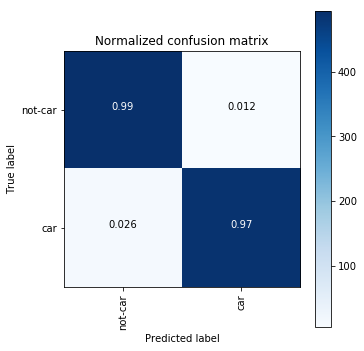

In [10]:
# Plot normalized confusion matrix
plt.figure(figsize=(5,5))
plot_confusion_matrix(cnf_matrix, classes=['not-car','car'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

# Hog Sub-sampling Window Search

The videofeed entering the pipeline is larger (1280x720) than the input classifier input (32x32).
In order to locate the car inside the image, we need to apply a technique that should athe 
This is a more efficient method than a sliding window technique.

This method allows us to execute the HOG algorithm features just once per frame.


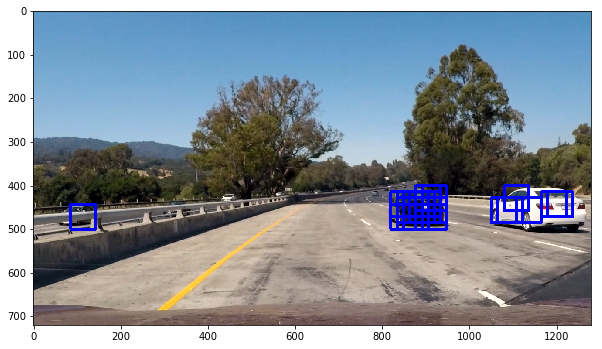

In [45]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2

spatial_size=(32, 32)

img = mpimg.imread('test_images/test1.jpg')

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 1  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    bbox_list = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3)).ravel()
            # print('hog_features size', len(hog_features))
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (32,32))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size).ravel()
            hist_features = color_hist(subimg, nbins=hist_bins).ravel()
            # Scale features and make a prediction
            feature_vec = np.concatenate((spatial_features, hist_features,hog_features)).ravel()
            test_features = X_scaler.transform(feature_vec.reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                bbox_list.append(((xbox_left, ytop_draw+ystart), (xbox_left+win_draw,ytop_draw+win_draw+ystart),))
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img, bbox_list
    
ystart = 400
ystop = 656
scale = 0.9
    
out_img, bbox_list = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

fig = plt.figure(figsize=(10,10))
plt.imshow(out_img)
plt.show()

## Heatmap

As you can notice, the detector returns multiple overlapping bounding boxes around the car. We can use simple technique to merge the boxes together: a heatmap.
The heatmap is effectively the calculation of a histogram of values on the images's regions.
When thresholded, the heatmap returns regions where the algorithm has high confidence areas than they contain a car. 


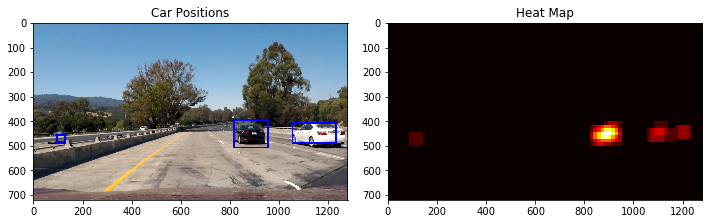

3 cars found


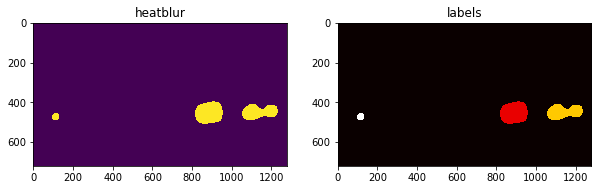

In [52]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
from scipy.ndimage.measurements import label

# Read in a pickle file with bboxes saved
# Each item in the "all_bboxes" list will contain a 
# list of boxes for one of the images shown above

# Read in image similar to one shown above 
image = np.copy(img)
heat = np.zeros_like(image[:,:,0]).astype(np.float)


def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    heatmap[heatmap > threshold] = 1
    # Return thresholded map
    return heatmap

def get_labeled_bboxes(labels):
    # Iterate through all detected cars
    bbox_list = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        bbox_list.append(bbox)
    return bbox_list

def draw_labeled_bboxes(img, bbox_list):
    image = np.copy(img)
    for bbox in bbox_list:
        cv2.rectangle(image, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return image
    
# Add heat to each box in box list
heat_hist = add_heat(heat,bbox_list)


# Visualize the heatmap when displaying    
heatmap = np.clip(heat_hist, 0, 255)

heatblur = cv2.GaussianBlur(heatmap,(0,0),12)
#heatblur[heatblur<1]=0
    
# Apply threshold to help remove false positives    
# Find final boxes from heatmap using label function
labels = label(apply_threshold(heatblur, .8))

labeled_bbox_list = get_labeled_bboxes(labels)
draw_img = draw_labeled_bboxes(img, labeled_bbox_list)


fig = plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()
plt.show()

print(labels[1], 'cars found')
fig = plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(heatblur)
plt.title('heatblur')
plt.subplot(122)
plt.imshow(labels[0], cmap='hot')
plt.title('labels')
plt.show()




## Video processing callback. 
This function chooses which lane finding algorithm to use as a function of the estimated quality of the algorithm.
The function choose between lane_sliding_window and poly_envelope_lane_search.


### Avoiding false positives,

In order to avoid false positives we will use a combination of labeled box thresholding, spatial filtering and temporal filtering.
+ Spatial filtering : I used gaussian filtering to group dis-connected boxes around a car together 
+ Temporal filtering : I successfully used a weighted average filter (FIR filter) on successive frames.
+ Labeled box thresholding: Only the strongest cell candidates should be retained.


In [57]:
# In order to stabilize 
class Filter:
    """
    
    This class is a static class. 
    Just one instance of the parameters is needed.
    """
    value = dict()
    
    def __init__(self):
        self.value = dict()
        self.z = None
        self.coeffs = np.array([0.05, 0.4, 0.55])
        self.index = 0
        self.bbox_list_z = list()
    
    def apply_coef_heat(self, heatblur):
        
        heat = np.zeros(shape=heatblur.shape)
        
        if self.z is None:
            self.z = np.zeros(shape=(heatblur.shape[0], heatblur.shape[1],
                                               self.coeffs.shape[0]))
        else:
            self.z[:,:, self.index] = heatblur
            for i, roll in zip(range(self.coeffs.shape[0]), range(self.index, self.index+self.coeffs.shape[0], 1)):
                roll_i = roll if roll < self.coeffs.shape[0] else roll - self.coeffs.shape[0]
                #print('(i, roll, roll_i):',(i, roll, roll_i))
                heat  = heat + self.z[:,:, roll_i] * self.coeffs[i]
            self.z[:, :, self.index] = heat
        
        self.index = self.index + 1 if self.index < self.coeffs.shape[0]-1 else 0
        
        
        return heat

            
            
    def get_z(self):
        return self.z


In [58]:
# Define callback for processing image

spatial_size=(32, 32)
ystart = 400
ystop = 656
scale = .85

def process_image(image, debug=False):
    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    out_img, bbox_list = find_cars(image, ystart, ystop, scale, svc, X_scaler,
                                   orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        
    # Add heat to each box in box list
    heat_hist = add_heat(heat,bbox_list)


    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat_hist, 0, 255)

    # Spatial filtering
    heatblur = cv2.GaussianBlur(heatmap,(0,0),15)
    
    if not debug:
        # Temporal filtering
        heatblur = filt.apply_coef_heat(heatblur)

    # Apply threshold to help remove false positives    
    # Find final boxes from heatmap using label function
    labels = label(apply_threshold(heatblur, 0.9))

    labeled_bbox_list = get_labeled_bboxes(labels)
    draw_img = draw_labeled_bboxes(image, labeled_bbox_list)
    
    return draw_img
    

# Testing pipeline on a few images




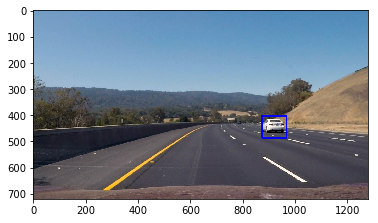

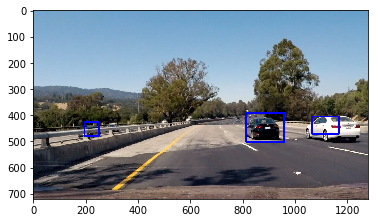

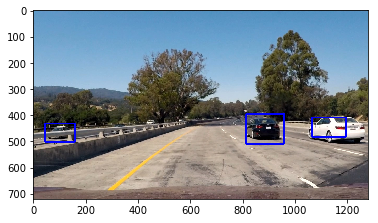

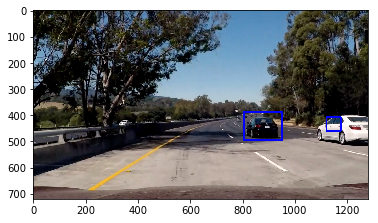

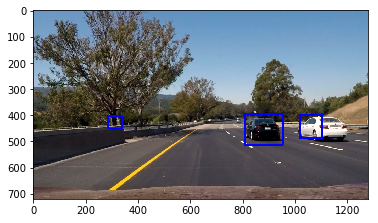

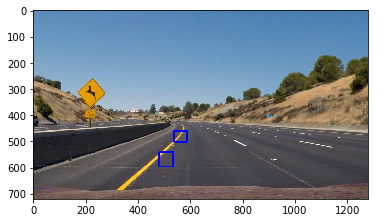

In [59]:

imgs_paths = glob.glob('./test_images/*.jpg', recursive=True)
for im_path in imgs_paths:
    filt = Filter()
    image = mpimg.imread(im_path)
    im_out = process_image(image, debug=True)
    plt.imshow(im_out)
    plt.show()

None


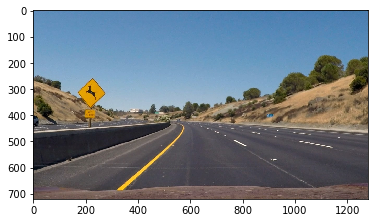

[MoviePy] >>>> Building video ./output_images/project_video.mp4
[MoviePy] Writing video ./output_images/project_video.mp4


100%|█████████▉| 1260/1261 [13:27<00:00,  1.57it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_images/project_video.mp4 

CPU times: user 17min 50s, sys: 1.64 s, total: 17min 52s
Wall time: 13min 27s


In [60]:

filt = Filter()
print(filt.get_z())

from moviepy.editor import VideoFileClip
clip = VideoFileClip("project_video.mp4")
plt.imshow(image)
plt.show()

#clip = VideoFileClip("./test_video.mp4")
video_output = './output_images/project_video.mp4'

processed_clip = clip.fl_image(process_image)

%time processed_clip.write_videofile(video_output, audio=False)


# Discussion

### Problems/issues faced
The most challenging part of this pipeline was to find parameter values that would reduce the number of false positives while keeping the pipeline accurate enough. 
I found challenging the following activities: 

+ Tuning of the classifier hyperparameters (I tackled this issue with a grid search optimizer)
+ Tuning the scale histogram threshold in the sliding window algorithm (still manually done)
+ Number of false positives and true negatives (I tackled this issue with spatial filtering - bluring of the heatmap - and temporal filtering - FIR/weighted average filter)

### How could the pipeline be  improved?
A HOG-based pipeline often requires manual tuning of hyper-parameters on an ensemble of stacked computer-vision techniques.
A more modern approch would be to use an end-to-end solution based on a Convolutional Neural Network.
This would speed-up the design/implementation time of the pipeline 
I would suggest implementing:
+ YOLO or SSD

One can improve the overall detection by combining various sensors data to the pipeline (Lidar+Radar+Stereo cameras) in order to perform the tracking of the vehicles.
This is called sensor fusion.

### What hypothetical cases would cause the pipeline to fail?
The classifier performance is limited by is complexity and the data it was trained on.
The data contains a limited set of time of vehicles and non-vehicle examples.
Also, we had to work around the high number of false positives and true negatives returned by the pipeline.
It would be easy to see that the pipeline would have a poor performance on poor lighting conditions (training data does not include these) and poor meteorological conditions (lacking in the training data).
